# Resampling and Model Validation
### Understanding Uncertainty

## Introduction
- Our empirical CDFs and kernel densities model our uncertainty about a phenomenon: Which brand gets sold? How long do patients live after treatment?
- This is what we call **first order uncertainty**: Uncertainty about outcomes -- we predict medians, means, quantiles, conditional expectations
- What we want to talk about this time is **second order uncertainty**: Uncertainty about our first order uncertainty. Is our prediction or model any good? How can we know?

## The Key Idea of Machine Learning
- We want new data to see if our models are useful: Do they make accurate predictions?
- We cannot typically get new data...
- But by randomly sampling our data and creating new, synthetic datasets, we can mimic the experience of confronting new data
- This allows us to quantify our second order uncertainty and use data-driven methods to make modeling choices
- These kinds of resampling methods are very powerful and provide a data-driven alternative to classical statistics 

## Outline
1. Quantifying Second-Order Uncertainty
2. Uncertainty About Model Quality

# 1. Quantifying Second Order Uncertainty

## Statistics
- A **statistic** is any quantity you compute from data: the min/max, IQR, median, kurtosis, regression coefficients, neural network weights...
- We are outrageously interested in statistics: What values do they take as the sample gets large? In repeated experiments, what value would the statistic take? What are reasonable ranges ?
- Ultimately, we are intersted in uncertainty about uncertainty: We have an estimate of some phenomenon, and want to know how noisy and uncertain that estimate is
- The **(Sampling) Distribution of a Statistic** is the distribution of a statistic: If we could run the experiment many times, what would the distribution of our statistic look like? What is our second order uncertainty about our estimate?
- But data scientists typically can't run new experiments to get new data. How do we learn about the distribution of the statistic?

## Case Resampling/Bootstrapping
- We typically can't run new experiments, we can mimic the arrival of new data in a clever way: Randomly select a dataset of the same size from the old one, **with replacement**
- This is called **case resampling** or **bootstrapping**
- By replacement, we mean that we "throw the data back in the pool" after each draw: We draw $N$ observations at random, and some will be drawn one or more times
- As long as the observations are independent, we can use this method to simulate what it would be like to get a new sample from the same data generating process
- If there are $N$ observations, there are $N^N$ ways to draw a new data set; even for 10 observations, $10^{10} = 10,000,000,000$, so for moderate or large datasets we have an almost inconceivable number of ways to resample
- Repeating this process allows us to simulate the distribution of outcomes: This is a brilliant way to probe uncertainty in a relatively costless way

## Resampling Methods
- Case resampling shows up all over statistics and machine learning:
    - Bootstrapping
    - Ensemble Learning ("bootstrap aggregation")
    - Cross Validation

## Bootstrapping
Suppose you have your data of interest, and a statistic computed from the data.

1. Sample $N$ observations **with replacement** (draw the $N$ observations one at a time from the pool, and replace each after being drawn; any observation can be chosen more than once).
2. Compute and save your value for the statistic of interest.
3. Repeat steps 1-2 a large number of times.
4. Plot the kde/ecdf of the saved values.

If the process that generated the data is stable over time, this procedure mimics the challenge of confronting new data

np.float64(129.09429138744105)

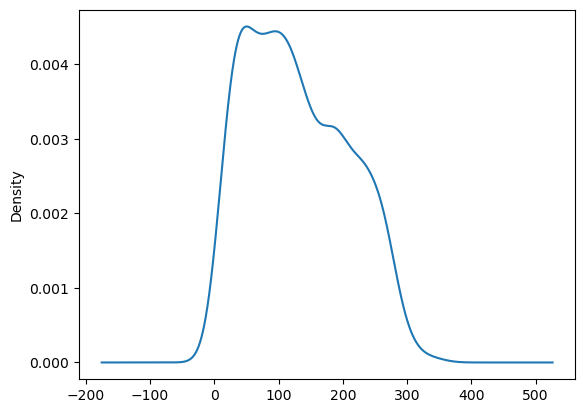

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./data/metabric.csv')
x = df['Overall Survival (Months)']
x.plot.kde()
x.mean()

### Bootstrapping the Mean
- The mean of a sample is
$$
\bar{x} = \frac{1}{N} \sum_{i=1}^N x_i
$$

In [2]:
## Our statistic to bootstrap:
def stat(x):
    stat = np.mean(x)
    return stat

In [24]:
def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S):
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates


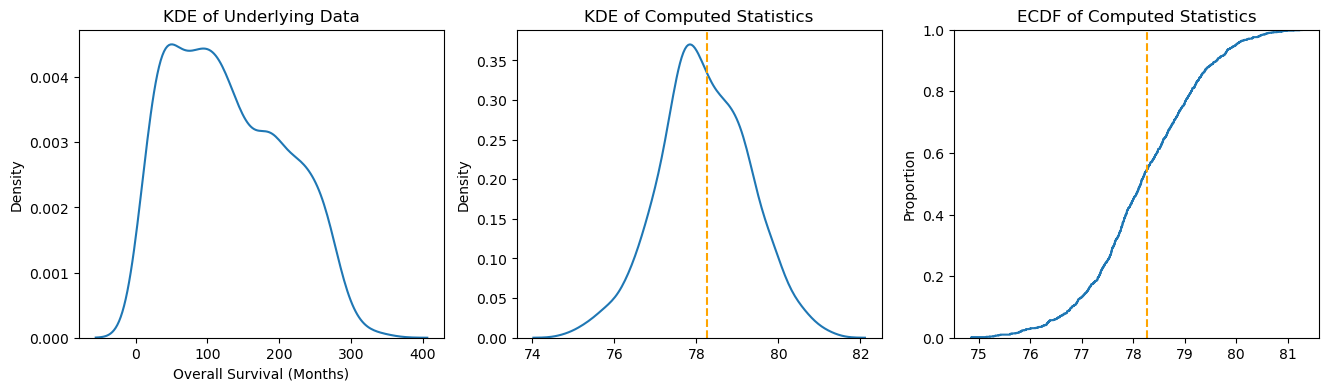

Variance of estimates is: 1.192437169351173


In [25]:
var = 'Overall Survival (Months)'
estimates = simulate(var, df, stat)

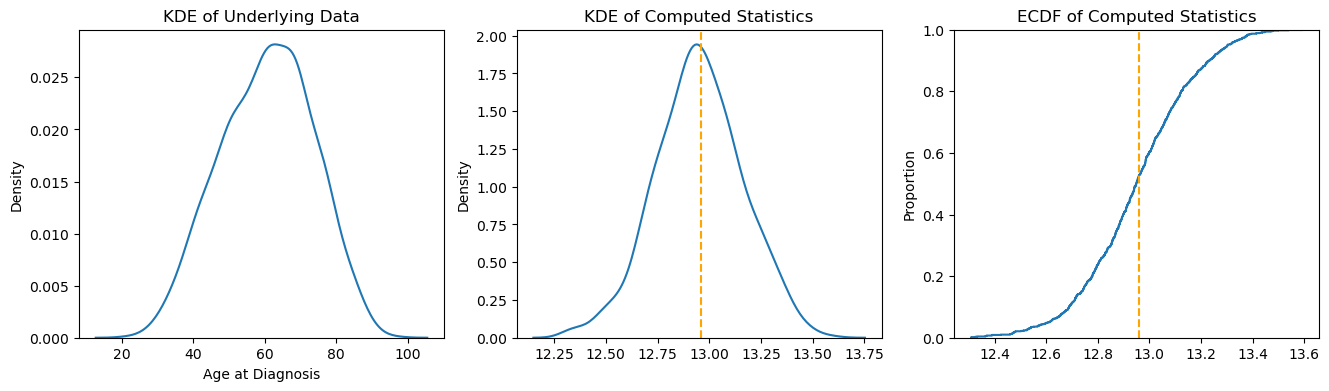

Variance of estimates is: 0.044681161158045296


In [26]:
var = 'Age at Diagnosis'
estimates = simulate(var, df, stat)

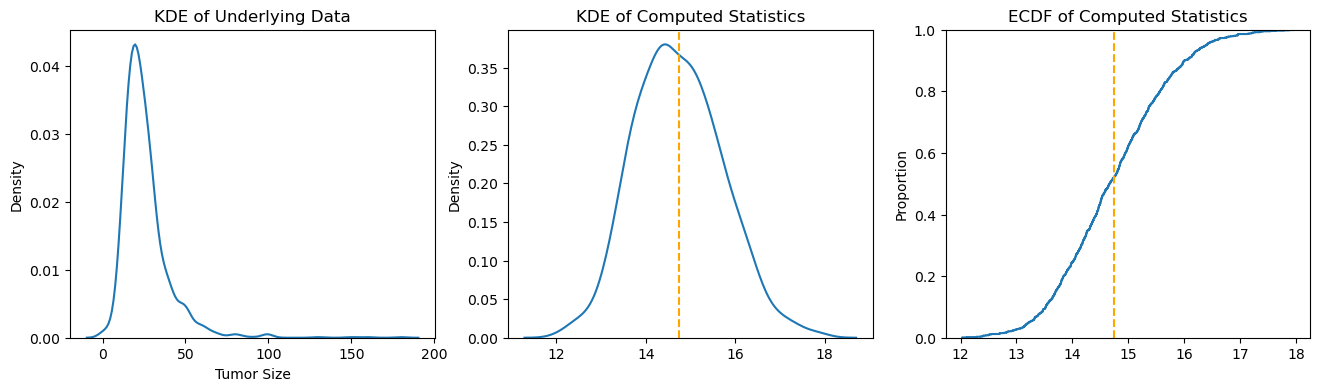

Variance of estimates is: 0.965794390896414


In [31]:
var = 'Tumor Size'
estimates = simulate(var, df, stat)

### Bootstrapping the IQR
- The interquartlie range is the difference between the .75- and .25- quantiles,
$$
IQR = \hat{F}_N^{-1}(.75) - \hat{F}_N^{-1}(.25)
$$

In [7]:
# Let's switch from the mean to the IQR

def stat(x):
    stat = np.quantile(x,.75) - np.quantile(x,.25)
    return stat

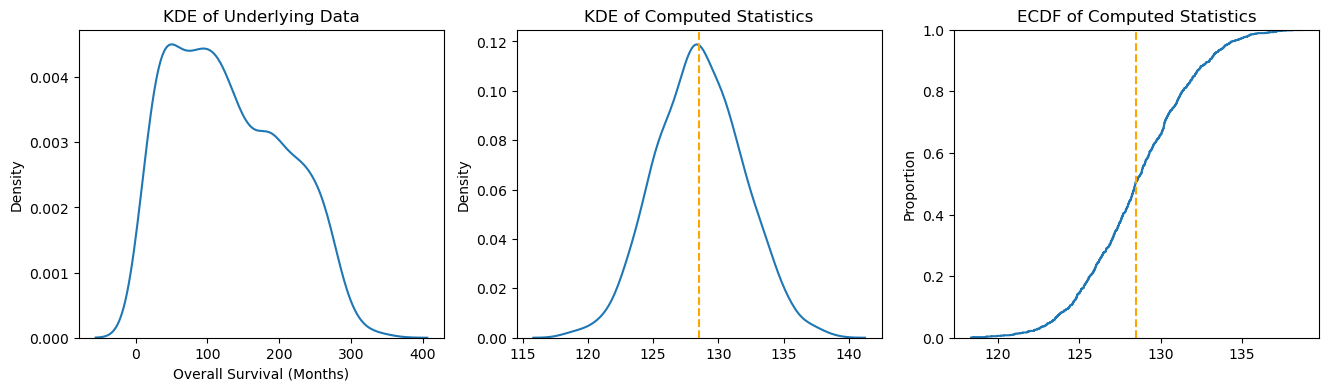

Variance of estimates is: 11.039838066389173


In [8]:
var = 'Overall Survival (Months)'
estimates = simulate(var, df, stat)

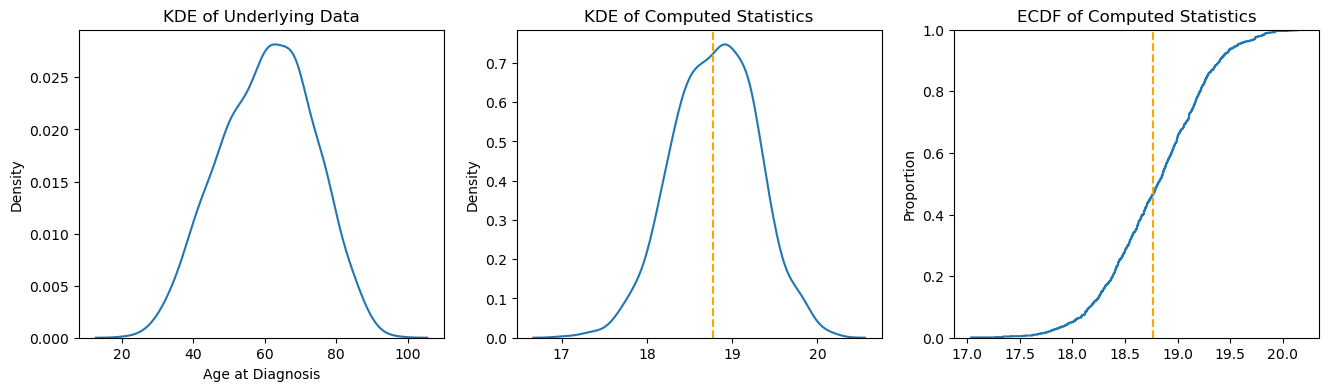

Variance of estimates is: 0.23833457697500024


In [9]:
var = 'Age at Diagnosis'
estimates = simulate(var, df, stat)

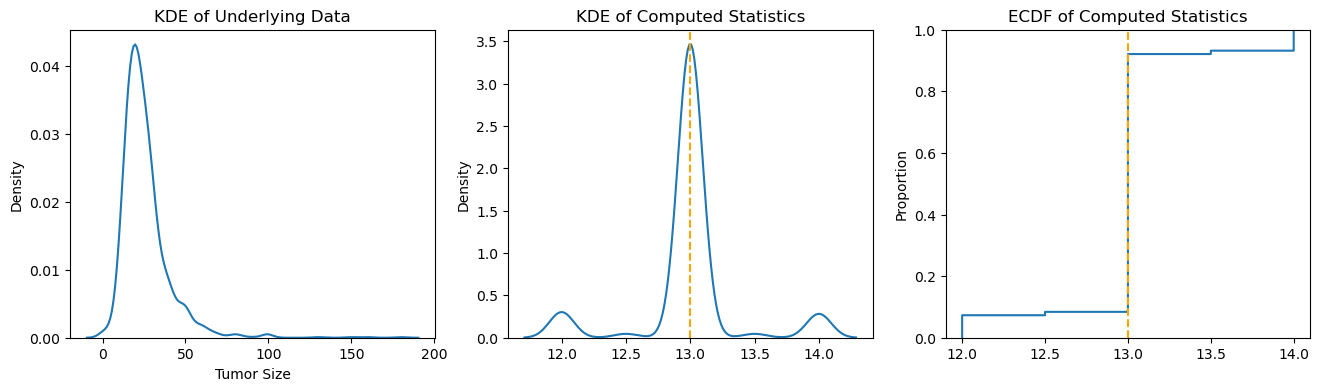

Variance of estimates is: 0.14647499999999997


In [10]:
var = 'Tumor Size'
estimates = simulate(var, df, stat)

### Bootstrapping the Standard Deviation
- The sample standard deviation is
$$
s_X = \sqrt{ \dfrac{1}{N} \sum_{i=1}^N (x_i - \bar{x})^2 }
$$

In [11]:
# What about the distribution of the standard deviation

def stat(x):
    stat = np.sqrt(np.var(x))
    return stat

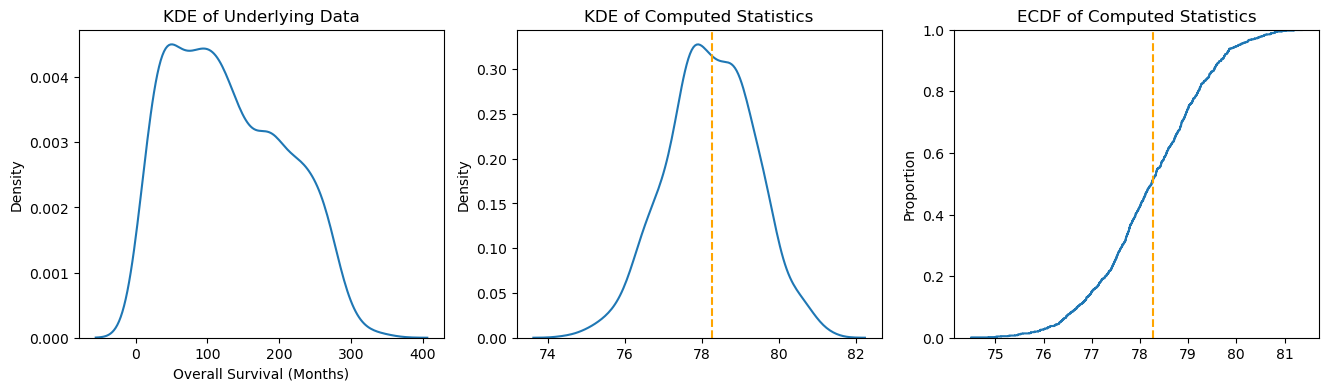

Variance of estimates is: 1.305170282568372


In [12]:
var = 'Overall Survival (Months)'
estimates = simulate(var, df, stat)

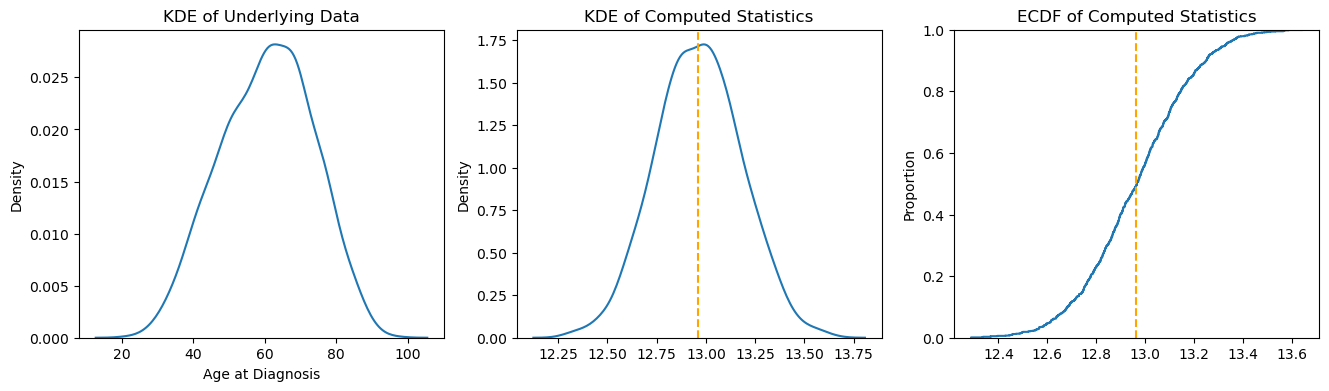

Variance of estimates is: 0.04727511953472435


In [13]:
var = 'Age at Diagnosis'
estimates = simulate(var, df, stat)

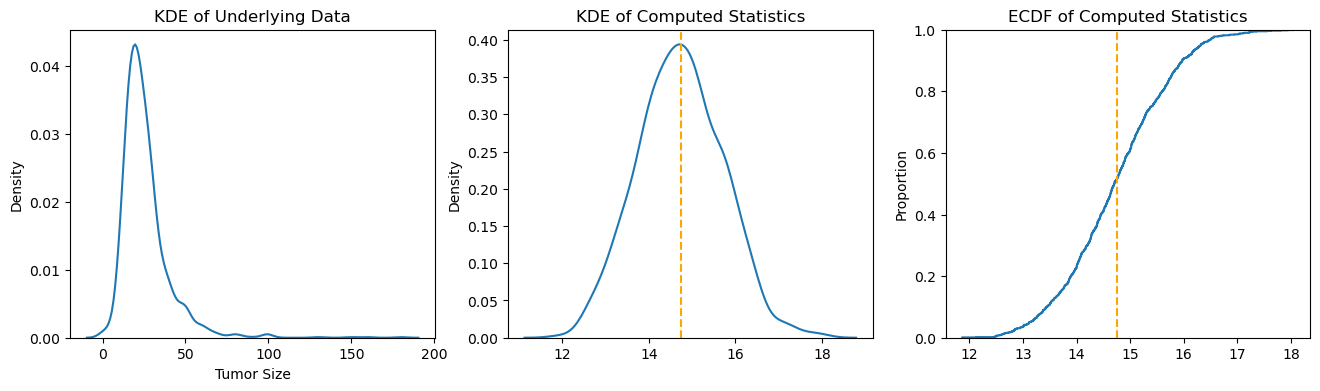

Variance of estimates is: 0.9585205983590929


In [14]:
var = 'Tumor Size'
estimates = simulate(var, df, stat)

## Visualizing the Sampling Distribution
- What shapes do the second and third plots take in the above figures?
- Notice that this is regardless of the shape in the first plot?
- Why?
- This is the core intuition of the field of statistics

## Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

## Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

## Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

## Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

## Probability: Limit Theorems
- What you're seeing here is a simulation example of a **limit theorem**: As the sample size gets large, statistics tend to converge
- In this case, what we're seeing is called the **Central Limit Theorem**: "Suppose $x_1, x_2, ...$ is a sequence of independent and identically distributed random variables drawn from a distribution with mean $\mu$ and variance $\sigma^2$. If 
$
\hat{x}_n = \frac{1}{n} \sum_{i=1}^n x_i,
$
then 
$
z_n = \sqrt{n} (\hat{x}_n - \mu)
$
converges in distribution to a Normal distribution with mean 0 and variance $\sigma^2$."
- Our plots above are illustrating how this concept works: Slight changes in the sample due to random bootstrap variation creates slight changes in the estimates across resamples, and this averages into a bell curve. 

# 2. Fit

## Loss and Fit 
- Let's pivot to a slightly different question
- We don't want to bootstrap a value, like the IQR or a difference in means. We liked that, and planting the seeds of hypothesis testing. But that's on pause for the moment.
- We want to explore the edges of the model. How, for example, do we pick the bandwidth?

## Likelihood and Log-Likelihood
- When we want to evaluate the fit of our model -- namely, a kernel density to data -- we have to choose $h$ to optimize something
- One of our core quantities for this task is the **likelihood**: Given the parameter value $h$, what's the probability of observing these data?
- If the observations are independent and identically distributed, this means we multiply the densities together for each observation:
$$
L[X|h] = \prod_{i=1}^N \hat{f}_{N,h}(x_i)
$$
- Multiplication is inconvenient, so we like to swap it for addition. If we take natural logs, we get the **log-likelihood**:
$$
\log(L[X|h]) = \sum_{i=1}^N \log\left( \hat{f}_{N,h}(x_i) \right)
$$
- If $h'$ makes the log-likelihood larger than $h$, then $h'$ is a more likely choice for the bandwidth than $h$

## Train-Test/Validation Splitting
- For reasons that will become clearer in a moment, simply maximizing $\log(L[X|h])$ does not work: The 
- Instead, we **split** the data into two **folds**: One set of data on which we build $\hat{f}_{N,h}(z)$, and then a second set of data on which we compute $\hat{f}_{N,h}(z)$ to evaluate the fit
- This approach is called a **train-test split**: Fit the model on the training data, evaluate its performance on the testing data

## Data Splitting
- Why are we doing this?
- We are fundamentally uncertain about the data that will show up tomorrow
- By splitting or resampling, we're trying to simulate the uncertainty of being confronted with new data, and finding out whether our model performs well or poorly
- If we test/validate models on the data on which they're trained, they'll always be overconfident and overfit 

## Example

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./data/metabric.csv')
x = df['Overall Survival (Months)']
df.head(10)

,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Chemotherapy,Hormone Therapy,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Overall Survival Status,Radio Therapy,TMB (nonsynonymous),Tumor Size,Tumor Stage
0,43.19,BREAST CONSERVING,Breast Cancer,NO,YES,0.0,2.0,4.020,84.633333,0:LIVING,YES,2.615035,10.0,1.0
1,48.87,MASTECTOMY,Breast Cancer,YES,YES,1.0,2.0,4.030,163.700000,1:DECEASED,NO,2.615035,15.0,2.0
2,47.68,MASTECTOMY,Breast Cancer,YES,YES,3.0,1.0,4.050,164.933333,0:LIVING,YES,1.307518,25.0,2.0
3,76.97,MASTECTOMY,Breast Cancer,YES,YES,8.0,2.0,6.080,41.366667,1:DECEASED,YES,2.615035,40.0,2.0
4,78.77,MASTECTOMY,Breast Cancer,NO,YES,0.0,4.0,4.062,7.800000,1:DECEASED,YES,5.230071,31.0,4.0
5,56.45,BREAST CONSERVING,Breast Cancer,YES,YES,1.0,4.0,4.020,164.333333,0:LIVING,YES,5.230071,10.0,2.0
6,89.08,BREAST CONSERVING,Breast Cancer,NO,YES,1.0,1.0,4.058,99.533333,1:DECEASED,YES,1.307518,29.0,2.0
7,86.41,BREAST CONSERVING,Breast Cancer,NO,YES,1.0,4.0,5.032,36.566667,1:DECEASED,YES,5.230071,16.0,2.0
8,84.22,MASTECTOMY,Breast Cancer,NO,NO,0.0,5.0,3.056,36.266667,1:DECEASED,NO,6.537589,28.0,2.0
9,85.49,MASTECTOMY,Breast Cancer,NO,YES,0.0,1.0,3.044,132.033333,1:DECEASED,YES,1.307518,22.0,4.0


In [16]:
class kde:
    ''' Kernel density estimator class.'''

    def __init__(self):
        self.h = None
        self.kernel = None
        self.grid_points = None
        self.n = None
        
    def kernel_function(self, u):
        ''' Kernel options for kde.'''
        if self.kernel == 'gaussian':
            return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
        elif self.kernel == 'uniform':
            return 0.5 * (np.abs(u) <= 1)
        elif self.kernel == 'triangular':
            return (1 - np.abs(u)) * (np.abs(u) <= 1)
        else:
            print("Unsupported kernel.")

    def fit(self, data, h = None, kernel_type = None, grid_points=200):
        '''Fit the kde estimator; automatically selects Silverman bandwidth.'''
        self.x = np.asarray(data)
        self.n = len(self.x)
        self.grid_points = grid_points

        # Kernel selection:
        if kernel_type is None:
            self.kernel = 'gaussian'
        else:
            self.kernel = kernel_type

        # Bandwidth selection:
        if h is None:
            self.h = 1.06 * np.sqrt( np.var(data) ) * self.n**(-0.2)
        else:
            self.h = h

        # Construct grid:
        margin = 2 * self.h
        self.grid = np.linspace(np.min(self.x) - margin, np.max(self.x) + margin, self.grid_points)

        # Compute KDE:
        diff_mat = (self.grid.reshape(1, -1) - self.x.reshape(-1, 1)) / self.h
        kernel_vals = self.kernel_function(diff_mat)/self.h
        self.density = np.mean(kernel_vals, axis=0) 

    def plot(self):
        '''Plot kernel density estimator.'''
        plt.plot(self.grid, self.density)
        plt.title(f"KDE with {self.kernel} kernel, h={self.h:.4f}")
        plt.xlabel("x")
        plt.ylabel("Density")
        plt.grid(True)
        plt.show()

    def predict(self, x_predict, h=None):
        '''Predict density values for values in x_predict.'''
        x_new = np.asarray(x_predict)
        # Compute predicted values:
        diff_mat = (x_new.reshape(1, -1) - self.x.reshape(-1, 1)) / self.h
        kernel_vals = self.kernel_function(diff_mat)/self.h
        f_hat = np.mean(kernel_vals, axis=0) 
        return f_hat

    def __repr__(self):
        self.plot()
        return (f"KDE Summary:\n"
                f"Kernel: {self.kernel}\n"
                f"Bandwidth: {self.h:.4f}\n")

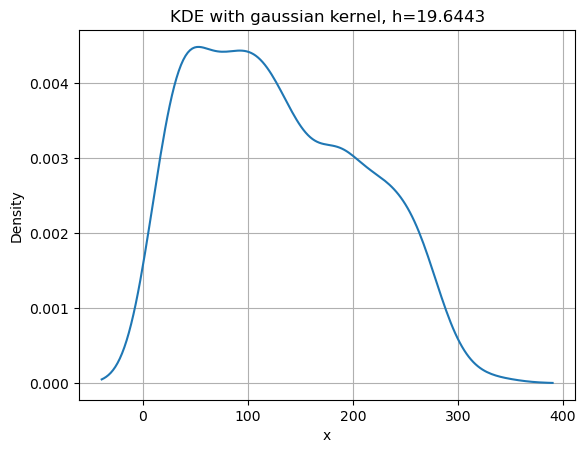

KDE Summary:
Kernel: gaussian
Bandwidth: 19.6443

In [17]:
kd = kde()
kd.fit(x)
kd

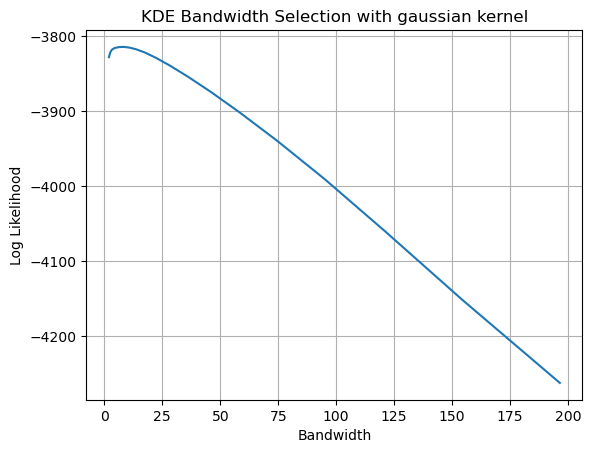

Optimal Bandwidth: 8.410377019524978


In [ ]:
df = df.sample(frac=1,random_state=100)

## Split the data into train and test
x = df['Overall Survival (Months)']
train_size = int(np.floor(len(x)/2))
x_train = x[:train_size]
x_test = x[train_size:]

## Build a bandwidth selection grid
s_x = np.sqrt(np.var(x))
h_s = 1.06 * s_x * len(x)**(-.2)
h_grid = h_s * np.logspace(-1.0, 1.0, 20)

## Compute log likelihood for each bandwidth
LL = []
for h in h_grid:
    kd.fit(x_train, h=h) # Fit the kernel density to the training data
    f_hat = kd.predict(x_test) # Predict values for the test set
    LL.append( np.sum( np.log( f_hat + 1e-12 ) ) ) # Save the log-likelihood

## Plot Log Likelihood:
plt.plot(h_grid, LL)
plt.title(f"KDE Bandwidth Selection with {kd.kernel} kernel")
plt.xlabel("Bandwidth")
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.show()

## Determine optimal bandwidth
h_star = h_grid[np.where(LL == np.max(LL))][0] # Why the [0]?
print(f'Optimal Bandwidth: {h_star}')

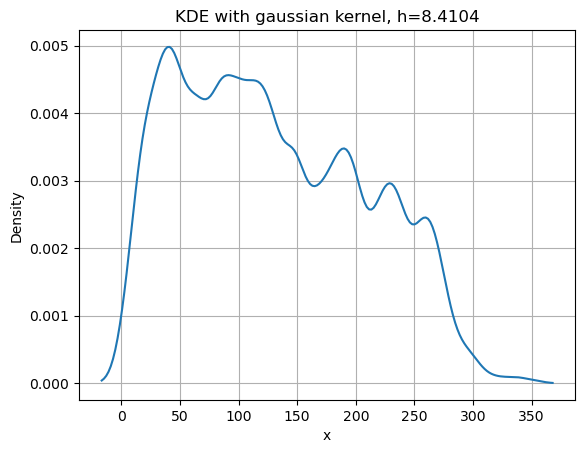

KDE Summary:
Kernel: gaussian
Bandwidth: 8.4104

In [ ]:
kd_data = kde() # Data-driven kde object
kd_data.fit(x,h=h_star) # Fit with the data-driven bandwidth
kd_data # Plot and summarize

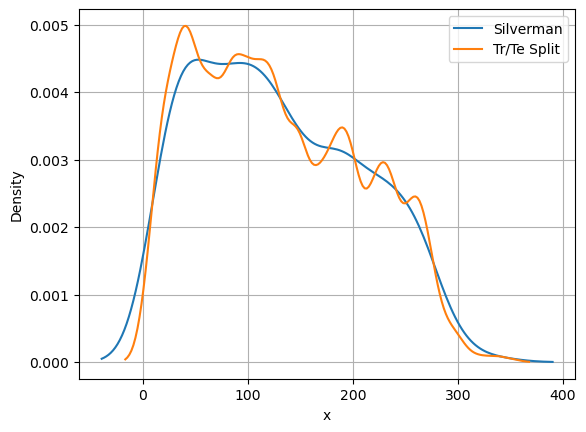

In [20]:
kd.fit(data=x)

plt.plot(kd.grid, kd.density, label = 'Silverman')
plt.plot(kd_data.grid, kd_data.density, label = 'Tr/Te Split')
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## Without the Split 

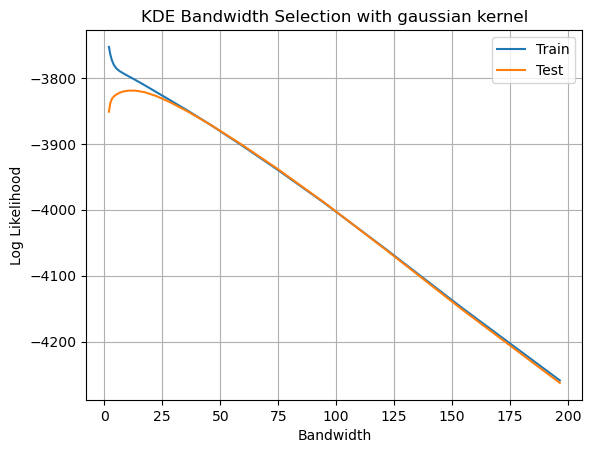

In [21]:
df = df.sample(frac=1,random_state=100)

## Split the data into train and test
x = df['Overall Survival (Months)']
train_size = int(np.floor(len(x)/2))
x_train = x[:train_size]
x_test = x[train_size:]

## Build a bandwidth selection grid
s_x = np.sqrt(np.var(x))
h_s = 1.06 * s_x * len(x)**(-.2)
h_grid = h_s * np.logspace(-1.0, 1.0, 20)

## Compute log likelihood for each bandwidth
LL_train = []
LL_test = []
for h in h_grid:
    kd.fit(x_train, h=h)
    f_hat = kd.predict(x_test)
    LL_test.append( np.sum( np.log( f_hat ) ) )
    f_hat = kd.predict(x_train)
    LL_train.append( np.sum( np.log( f_hat ) ) )
    

## Plot Log Likelihood
plt.plot(h_grid, LL_train, label='Train')
plt.plot(h_grid, LL_test, label='Test')
plt.title(f"KDE Bandwidth Selection with {kd.kernel} kernel")
plt.legend()
plt.xlabel("Bandwidth")
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.show()


- The error on the training data is monotonically decreasing: You'd pick the smallest bandwidth possible. Why?
- The error on the testing data increases and then decreases, so there's an optimal bandwidth
- For model selection questions, we need to separate the data on which the model is fit from the data by which we judge performance, or we will almost certainly overfit the data (here, pick a too-small bandwidth)

## From Train/Test Split to Cross Validation
- Instead of simply doing a two-way split, we can split the data into $k$ equal chunks to get $k$ estimates of model performance
- In particular, we fit the model $K$ times, training it on $K-1$ chunks and testing it on the $K$-th; this is called $K$-Fold Cross Validation
- More chunks trains on more data points and gives more estimates of model performance, but is more costly to compute

![Cross Validation](./src/crossvalidation.png)

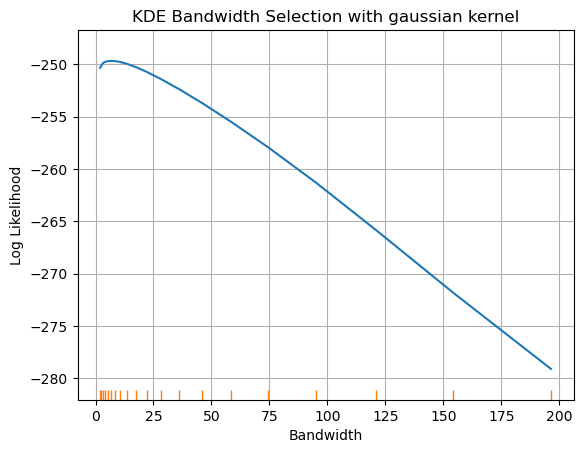

Optimal Bandwidth: [6.60012722]


In [33]:
kd = kde()

df = df.sample(frac=1,random_state=100)
x = df['Overall Survival (Months)'].values # Data to use for 

K = 30 # Number of folds

## Create K folds
index = np.arange(len(x)) # Index values for the folds
per_fold = len(x)//K # Data per fold
folds = index[:per_fold*K].reshape(K,per_fold) # Matrix of data indices

## Build a bandwidth selection grid
s_x = np.sqrt(np.var(x)) # sample standard deviation
h_s = 1.06 * s_x * len(x)**(-.2) # silverman plug-in for a guess 
h_grid = h_s * np.logspace(-1.0, 1.0, 20) # a grid of values for bandwidth

## Compute log likelihood for each fold
LL = [] # Object to save average log-likelihood per fold
LL_all = [] # Object to save all of the log-likelihood values
for h in h_grid:
    LL_inner = [] # Object to save log-likelihoods at the fold-level
    for k in range(K): # For each fold...
        test_indices = folds[k] # Test fold indices
        x_train = np.delete(x, test_indices) # Select training data
        x_test = x[test_indices] # Select test data
        kd.fit(x_train, h=h) # Fit the kde on training data
        f_hat = kd.predict(x_test) # Predict outcomes for test data
        LL_inner.append(np.sum(np.log(f_hat + 1e-12))) # Compute log-likelihood
    LL.append(np.mean(LL_inner)) # Save the average LL of the K folds
    LL_all.append(LL_inner) # Save all the estimates for fun

## Plot Log Likelihood:
plt.plot(h_grid, LL)
plt.title(f"KDE Bandwidth Selection with {kd.kernel} kernel")
plt.xlabel("Bandwidth")
sns.rugplot(h_grid)
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.show()

## Determine optimal bandwidth
h_star = h_grid[np.where(LL == np.max(LL))]
print(f'Optimal Bandwidth: {h_star}')

[Text(0.5, 1.0, 'Errors for each fold')]

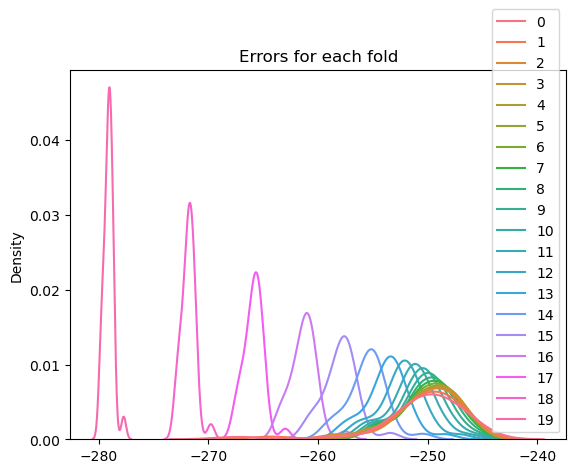

In [23]:
sns.kdeplot(LL_all).set(title='Errors for each fold')

## Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

## Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference

## Conclusion
- Resampling with Replacement
- Bootstrapping
- 90% Confidence Interval
- Train-Test Split
- $K$-Fold Cross Validation